In [1]:
EXP_NAME = 'LUCAS_Self560_ViT_Trans'

In [2]:
from train_SimCLR_utils import *
import torch
from torch.utils.data import DataLoader
from dataset.dataset_loader import SNDataset,SNDatasetClimate, myNormalize, myToTensor, Augmentations
from torchvision import transforms
import random
import numpy as np
from dataset.utils.utils import TextColors as tc
from plot_utils.plot import plot_train_test_losses
from datetime import date, datetime
import torch.nn.functional as F
import cv2
import json

In [3]:
DATASET = 'LUCAS' # 'LUCAS', 'RaCA'

if DATASET == 'LUCAS':
    from dataset.dataset_loader import SNDataset,SNDatasetClimate, myNormalize, myToTensor, Augmentations
    OC_MAX = 560.2
if DATASET == 'RaCA':
    from dataset.dataset_loader import SNDataset,SNDatasetClimate, myNormalize, myToTensor, Augmentations
    OC_MAX = 4115

In [4]:
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results_simclr_lucas'):
    os.mkdir('results_simclr_lucas')

In [5]:
# Format the date and time
now = datetime.now()
start_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", start_string)

Current Date and Time: 2024-03-04 08:48:39


In [6]:
import os
os.getcwd()

NAFISEH = "Nafiseh"
MOIEN = "Moien"

if "d:" in os.getcwd():
    USER = MOIEN
elif "c:" in os.getcwd():
    USER = NAFISEH
else:
    raise Exception("Unknown user")

USER

'Nafiseh'

In [7]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
# CONFIG
NUM_WORKERS = 6 if USER == NAFISEH else 2
TRAIN_BATCH_SIZE = 32 if USER == NAFISEH else 4
TEST_BATCH_SIZE = 32 if USER == NAFISEH else 4
LEARNING_RATE = 1e-4 if USER == NAFISEH else 1e-4
NUM_EPOCHS = 40 if USER == NAFISEH else 2
LR_SCHEDULER = "step" # step, plateau or None

USE_SRTM = True

USE_SPATIAL_ATTENTION = False if USER == NAFISEH else False
CNN_ARCHITECTURE = 'ViT' # vgg16 or resnet101 or "ViT"
RNN_ARCHITECTURE = 'Transformer' # LSTM, GRU, RNN, Transformer
REG_VERSION = 1 if USER == NAFISEH else 2
USE_LSTM_BRANCH = True

In [9]:

if USE_SRTM:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)], [(12), (-4,2963)], [(13), (0, 90)]], oc_min = 0, oc_max = OC_MAX)
else:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)]], oc_min = 0, oc_max = OC_MAX)
    
my_to_tensor = myToTensor()
my_augmentation = Augmentations()
train_transform = transforms.Compose([mynorm, my_to_tensor,my_augmentation])
test_transform = transforms.Compose([mynorm, my_to_tensor])

In [10]:
if USER == MOIEN:
    train_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\train\\'
    test_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\test\\'
    val_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\val\\'
    testval_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\val\\'
    lucas_csv_path = 'D:\python\SoilNet\dataset\LUCAS_2015_all.csv'
    climate_csv_folder_path = "D:\\python\\SoilNet\\dataset\\Climate\\All\\filled\\"


elif USER == NAFISEH:

    if DATASET == 'LUCAS':
     train_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images\\train'
     test_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images\\test'
     val_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images\\val'
     testval_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images\\val'
     # lucas_csv_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\LUCAS_2015_all.csv'
    #  lucas_csv_path = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\simclr\\simclr.csv" # The LUCAS will be replaced by SimCLR file
     lucas_csv_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\simclr\\LUCAS_SimCLR_1.csv'
     # climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\Climate\\All\\filled'
     climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\Climate\\LUCAS_SimCLR_Cleaned'


    # if DATASET == 'RaCA':
    #  train_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images_simclr_RaCA\\train'
    #  test_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images_simclr_RaCA\\test'
    #  val_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images_simclr_RaCA\\val'
    #  testval_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images_simclr_RaCA\\test_val'
    #  # lucas_csv_path = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\RapidCarbon_OC.csv"
    #  lucas_csv_path = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\simclr\\simclr_RaCA.csv"
    #  climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\Climate\\RaCA_SimCLR\\filled'

In [11]:
bands = [0,1,2,3,4,5,6,7,8,9,10,11] if not USE_SRTM else [0,1,2,3,4,5,6,7,8,9,10,11,12,13]


################################# IF Not USE_LSTM_BRANCH ###############################
if not USE_LSTM_BRANCH: # NOT USING THE CLIMATE DATA

    train_ds = SNDataset(train_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=train_transform)
    test_ds =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    val_ds = SNDataset(val_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    test_ds_w_id =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    testval_ds_w_id =  SNDataset(testval_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    
################################### IF USE_LSTM_BRANCH #################################
else: # USING THE CLIMATE DATA
    train_ds = SNDatasetClimate(train_l8_folder_path,
                                    lucas_csv_path,
                                    climate_csv_folder_path,
                                    l8_bands=bands, transform=train_transform)

    test_ds = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    val_ds = SNDatasetClimate(val_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    test_ds_w_id = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)

    testval_ds_w_id = SNDatasetClimate(testval_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)
    


In [12]:
SEQ_LEN = test_ds_w_id[0][0][1].shape[0]
SEQ_LEN # max sequence length for Transformer model set up

61

In [13]:
# COUNTING the csv files in the csv folder
CSV_FILES = [f for f in os.listdir(climate_csv_folder_path) if f.endswith('.csv')]
NUM_CLIMATE_FEATURES = len(CSV_FILES)
NUM_CLIMATE_FEATURES

11

In [14]:
from soilnet.soil_net import SoilNet, SoilNetLSTM, SoilNetSimCLR

__name__: submodules.src.transformer.transformer


In [15]:
# train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# # Get image and label from custom DataLoader
# img_custom, climate,label_custom = next(iter(train_dl))
# print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
# print(f"Climate shape: {climate.shape} -> [batch_size, climate_channels]")
# print(f"Label shape: {label_custom.shape}")
# img_gpu = img_custom.to(device)
# print(img_gpu.device, img_gpu.shape)
# print(img_gpu.shape)
# y = model(img_gpu)
# y.detach()

In [16]:
cv_results = {"train_loss": [],
                "train_acc_top1": [],
                "train_acc_top5": [],
                "train_acc_mean_pos": [],
                "val_loss": [],
                "val_acc_top1": [],
                "val_acc_top5": [],
                "val_acc_mean_pos": [],
    }

In [17]:
from datetime import date, datetime
# Format the date and time
now = datetime.now()
run_name = now.strftime("D_%Y_%m_%d_T_%H_%M")
print("Current Date and Time:", run_name)
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

Current Date and Time: D_2024_03_04_T_08_49


In [18]:
# SEEDS = [75] 
SEEDS = [1]  if USER == MOIEN else [1, 4]
# SEEDS = [1] if USER == MOIEN else [1, 4, 69, 75, 79, 128, 474, 786, 2048, 3333]

In [19]:
best_mae = 1000 # just a big number, since our data is normalized between 0 and 1, mae is between 0 and 1 too.
best_seed = SEEDS[0]
for idx, seed in enumerate(SEEDS):
    print(tc.BOLD_BAKGROUNDs.PURPLE, f"CROSS VAL {idx+1}", tc.ENDC)
    
    
    train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    val_dl = DataLoader(val_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    #model = SoilNetFC(cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
    # architecture = "101+GLAM" if USE_SPATIAL_ATTENTION else "101"
    if USE_LSTM_BRANCH:
        model = SoilNetSimCLR(use_glam=USE_SPATIAL_ATTENTION, cnn_arch= CNN_ARCHITECTURE, reg_version= REG_VERSION,
                           cnn_in_channels=len(bands), regresor_input_from_cnn=128,
                           lstm_n_features= NUM_CLIMATE_FEATURES, lstm_n_layers= 2, lstm_out= 128,
                           hidden_size=128, rnn_arch=RNN_ARCHITECTURE,seq_len=SEQ_LEN).to(device)
    else:
        model = SoilNet(use_glam=USE_SPATIAL_ATTENTION, cnn_arch = CNN_ARCHITECTURE, reg_version= REG_VERSION,
                       cnn_in_channels=len(bands), regresor_input_from_cnn=128, hidden_size=128).to(device)
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Saving the model on the last epoch
    save_model_path = f"results/RUN_{EXP_NAME}_{run_name}_{USER}.pth.tar"
    
    results = train(model, train_dl, test_dl, val_dl,
                    torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
                    SimCLR(temperature=0.5), epochs=NUM_EPOCHS, lr_scheduler=LR_SCHEDULER,
                    save_model_path= save_model_path,
                    save_model_if_mae_lower_than= best_mae,
                    )

    
    cv_results['train_loss'].append(results['train_loss'])
    cv_results['train_acc_top1'].append(results['train_acc_top1'])
    cv_results['train_acc_top5'].append(results['train_acc_top5'])
    cv_results['train_acc_mean_pos'].append(results['train_acc_mean_pos'])
    cv_results['val_loss'].append(results['val_loss'])
    cv_results['val_acc_top1'].append(results['val_acc_top1'])
    cv_results['val_acc_top5'].append(results['val_acc_top5'])
    cv_results['val_acc_mean_pos'].append(results['val_acc_mean_pos'])
    

    # if results['MAE'][0] < best_mae:
    #     best_mae = results['MAE'][0]
    #     best_seed = seed
    #     print(tc.BOLD_BAKGROUNDs.GREEN, f"MAE improved to {best_mae}", tc.ENDC)
    
        

 CROSS VAL 1 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.59it/s, Train_Loss=3.35]


 Epoch 1 Results: |  train_loss: 3.3532735086942504 |  val_loss: 3.063500313132022  train_acc_top1: 0.07999254206956273 |  val_acc_top1: 0.12221537558405612  train_acc_top5: 0.3521768632629108 |  val_acc_top5: 0.5187309272412403  train_acc_mean_pos: 12.840580374702041 |  val_acc_mean_pos: 7.25860328629543  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 1704/1704 [03:43<00:00,  7.63it/s, Train_Loss=2.98]


 Epoch 2 Results: |  train_loss: 2.9827731402826982 |  val_loss: 2.9797160843728294  train_acc_top1: 0.18301606514084506 |  val_acc_top1: 0.19396273469980893  train_acc_top5: 0.6083663438967136 |  val_acc_top5: 0.6344806337860268  train_acc_mean_pos: 6.060384878740065 |  val_acc_mean_pos: 5.832972417974696  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 1704/1704 [03:43<00:00,  7.61it/s, Train_Loss=2.92]


 Epoch 3 Results: |  train_loss: 2.9158082591815733 |  val_loss: 2.948641383591952  train_acc_top1: 0.24532656006060297 |  val_acc_top1: 0.20536825116811225  train_acc_top5: 0.689294185262051 |  val_acc_top5: 0.6498591548680139  train_acc_mean_pos: 5.033618813669178 |  val_acc_mean_pos: 5.424922241851197  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 1704/1704 [03:43<00:00,  7.62it/s, Train_Loss=2.87]


 Epoch 4 Results: |  train_loss: 2.869849876548763 |  val_loss: 2.8449897391135703  train_acc_top1: 0.28185213713998525 |  val_acc_top1: 0.31070275821596244  train_acc_top5: 0.7326327758215962 |  val_acc_top5: 0.7437235914485555  train_acc_mean_pos: 4.518244449311579 |  val_acc_mean_pos: 4.274304577442402  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 1704/1704 [03:42<00:00,  7.65it/s, Train_Loss=2.84]


 Epoch 5 Results: |  train_loss: 2.841607510274005 |  val_loss: 2.824819307372044  train_acc_top1: 0.3082391921203461 |  val_acc_top1: 0.2996728285937242  train_acc_top5: 0.7567396566901409 |  val_acc_top5: 0.7674647887267977  train_acc_mean_pos: 4.210894708552271 |  val_acc_mean_pos: 4.0673195420296535  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 1704/1704 [03:43<00:00,  7.64it/s, Train_Loss=2.82]


 Epoch 6 Results: |  train_loss: 2.8175668855648084 |  val_loss: 2.815533054266737  train_acc_top1: 0.33303073650234744 |  val_acc_top1: 0.3150821595404629  train_acc_top5: 0.7791960093896714 |  val_acc_top5: 0.7764509976469854  train_acc_mean_pos: 3.9540694688967135 |  val_acc_mean_pos: 3.9381734155153443  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 1704/1704 [03:42<00:00,  7.68it/s, Train_Loss=2.8]


 Epoch 7 Results: |  train_loss: 2.7966199680253374 |  val_loss: 2.7738380448918947  train_acc_top1: 0.3517458920187793 |  val_acc_top1: 0.37018926056897694  train_acc_top5: 0.7980578785211268 |  val_acc_top5: 0.8197681924826662  train_acc_mean_pos: 3.727461120892019 |  val_acc_mean_pos: 3.4883729460093895  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 1704/1704 [03:45<00:00,  7.56it/s, Train_Loss=2.78]


 Epoch 8 Results: |  train_loss: 2.7811831615060707 |  val_loss: 2.789650045090438  train_acc_top1: 0.3715950215296566 |  val_acc_top1: 0.36030223000217493  train_acc_top5: 0.8130226672535211 |  val_acc_top5: 0.8138365609824937  train_acc_mean_pos: 3.5686466891860738 |  val_acc_mean_pos: 3.5592356220657275  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.58it/s, Train_Loss=2.77]


 Epoch 9 Results: |  train_loss: 2.767548678626477 |  val_loss: 2.7408553473826305  train_acc_top1: 0.387669331975666 |  val_acc_top1: 0.4328447769225483  train_acc_top5: 0.8271530223004695 |  val_acc_top5: 0.8522593896713615  train_acc_mean_pos: 3.4179106758374003 |  val_acc_mean_pos: 3.11504401399496  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 1704/1704 [03:47<00:00,  7.47it/s, Train_Loss=2.75]


 Epoch 10 Results: |  train_loss: 2.7530174590472325 |  val_loss: 2.7494244413196762  train_acc_top1: 0.40697745503114424 |  val_acc_top1: 0.4235563380337657  train_acc_top5: 0.8413108861502347 |  val_acc_top5: 0.8383582746478874  train_acc_mean_pos: 3.2601171263926467 |  val_acc_mean_pos: 3.2265375586742526  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 1704/1704 [04:21<00:00,  6.52it/s, Train_Loss=2.7]


 Epoch 11 Results: |  train_loss: 2.696559253712775 |  val_loss: 2.679952147421143  train_acc_top1: 0.48095779540673106 |  val_acc_top1: 0.5196948356471711  train_acc_top5: 0.8810244278169014 |  val_acc_top5: 0.8952362088250442  train_acc_mean_pos: 2.778196522887324 |  val_acc_mean_pos: 2.5813350940534208  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 1704/1704 [04:20<00:00,  6.54it/s, Train_Loss=2.68]


 Epoch 12 Results: |  train_loss: 2.6801941266781846 |  val_loss: 2.6754576242026027  train_acc_top1: 0.5004126320422535 |  val_acc_top1: 0.5244204811926739  train_acc_top5: 0.8921654929577465 |  val_acc_top5: 0.8981338027217578  train_acc_mean_pos: 2.6446596244131455 |  val_acc_mean_pos: 2.5607482393582663  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 1704/1704 [03:52<00:00,  7.32it/s, Train_Loss=2.67]


 Epoch 13 Results: |  train_loss: 2.67308314396462 |  val_loss: 2.6695622670258716  train_acc_top1: 0.5093529929577465 |  val_acc_top1: 0.5281514084674943  train_acc_top5: 0.8977131015258216 |  val_acc_top5: 0.9007746477921804  train_acc_mean_pos: 2.5897428843896715 |  val_acc_mean_pos: 2.5109184272412404  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.74it/s, Train_Loss=2.67]


 Epoch 14 Results: |  train_loss: 2.6683763986182325 |  val_loss: 2.6804145703293347  train_acc_top1: 0.5178562695851349 |  val_acc_top1: 0.5064275233958249  train_acc_top5: 0.9000696889671361 |  val_acc_top5: 0.8931088614072038  train_acc_mean_pos: 2.5594342967993775 |  val_acc_mean_pos: 2.6185108568746718  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 1704/1704 [03:39<00:00,  7.76it/s, Train_Loss=2.66]


 Epoch 15 Results: |  train_loss: 2.658834403599372 |  val_loss: 2.6619592233442924  train_acc_top1: 0.5252928159466372 |  val_acc_top1: 0.5384316314274157  train_acc_top5: 0.9070660944835681 |  val_acc_top5: 0.9066431923931193  train_acc_mean_pos: 2.4866276652740202 |  val_acc_mean_pos: 2.459421948368001  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 1704/1704 [03:48<00:00,  7.45it/s, Train_Loss=2.66]


 Epoch 16 Results: |  train_loss: 2.6562924167499857 |  val_loss: 2.654599889903001  train_acc_top1: 0.5287436424216754 |  val_acc_top1: 0.5510123239156786  train_acc_top5: 0.9089183538732394 |  val_acc_top5: 0.9137954811255137  train_acc_mean_pos: 2.4647184321438202 |  val_acc_mean_pos: 2.3879518777551785  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 1704/1704 [04:05<00:00,  6.93it/s, Train_Loss=2.65]


 Epoch 17 Results: |  train_loss: 2.648138537723134 |  val_loss: 2.6589709503549925  train_acc_top1: 0.5359754010405339 |  val_acc_top1: 0.5470715962665181  train_acc_top5: 0.9133014231220657 |  val_acc_top5: 0.907219776944935  train_acc_mean_pos: 2.4142672877776232 |  val_acc_mean_pos: 2.439028755879738  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 1704/1704 [03:43<00:00,  7.62it/s, Train_Loss=2.65]


 Epoch 18 Results: |  train_loss: 2.645009145000731 |  val_loss: 2.644586482518156  train_acc_top1: 0.5442952856141636 |  val_acc_top1: 0.566657863872152  train_acc_top5: 0.9150894953051644 |  val_acc_top5: 0.9184903168062649  train_acc_mean_pos: 2.3921440971989028 |  val_acc_mean_pos: 2.331456866062863  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.59it/s, Train_Loss=2.64]


 Epoch 19 Results: |  train_loss: 2.6413297748341806 |  val_loss: 2.6490288194916056  train_acc_top1: 0.5481618006884212 |  val_acc_top1: 0.5596522887547811  train_acc_top5: 0.9177303403755869 |  val_acc_top5: 0.9147857980269222  train_acc_mean_pos: 2.3653382971672943 |  val_acc_mean_pos: 2.374417546769263  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.59it/s, Train_Loss=2.64]


 Epoch 20 Results: |  train_loss: 2.635787965056482 |  val_loss: 2.644822997106633  train_acc_top1: 0.5555280467643984 |  val_acc_top1: 0.5656514083835441  train_acc_top5: 0.9215540639671361 |  val_acc_top5: 0.9172432510785653  train_acc_mean_pos: 2.3213272691472597 |  val_acc_mean_pos: 2.3396684272748205  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 21
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.60it/s, Train_Loss=2.62]


 Epoch 21 Results: |  train_loss: 2.620221506192091 |  val_loss: 2.6255597698856405  train_acc_top1: 0.5779018730554782 |  val_acc_top1: 0.597954812184186  train_acc_top5: 0.9311454665492958 |  val_acc_top5: 0.9283568074165935  train_acc_mean_pos: 2.2106226770111093 |  val_acc_mean_pos: 2.1981572769057585  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 22
------------------------------- 


100%|██████████| 1704/1704 [03:45<00:00,  7.57it/s, Train_Loss=2.62]


 Epoch 22 Results: |  train_loss: 2.6170561712392617 |  val_loss: 2.623523702084179  train_acc_top1: 0.5819578931924883 |  val_acc_top1: 0.602723004672449  train_acc_top5: 0.9325300762910798 |  val_acc_top5: 0.92989730037434  train_acc_mean_pos: 2.18865536971831 |  val_acc_mean_pos: 2.1799603874134905  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 23
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.58it/s, Train_Loss=2.62]


 Epoch 23 Results: |  train_loss: 2.6166053926441033 |  val_loss: 2.6264426669044676  train_acc_top1: 0.5838590571438202 |  val_acc_top1: 0.5943705985243891  train_acc_top5: 0.9337679724178404 |  val_acc_top5: 0.9288703050691757  train_acc_mean_pos: 2.1842539612676055 |  val_acc_mean_pos: 2.2031983568075115  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 24
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.60it/s, Train_Loss=2.61]


 Epoch 24 Results: |  train_loss: 2.6139977158095355 |  val_loss: 2.620511684619205  train_acc_top1: 0.5865763155437411 |  val_acc_top1: 0.6123224765482084  train_acc_top5: 0.9334928843896714 |  val_acc_top5: 0.9318045773696452  train_acc_mean_pos: 2.1736600156261328 |  val_acc_mean_pos: 2.1552127347865575  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 25
------------------------------- 


100%|██████████| 1704/1704 [03:43<00:00,  7.61it/s, Train_Loss=2.61]


 Epoch 25 Results: |  train_loss: 2.612550166361209 |  val_loss: 2.622655277520838  train_acc_top1: 0.5859680653597827 |  val_acc_top1: 0.6048136736865335  train_acc_top5: 0.9343823356807511 |  val_acc_top5: 0.9296772299518048  train_acc_mean_pos: 2.172150088028169 |  val_acc_mean_pos: 2.179724178403756  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 26
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.60it/s, Train_Loss=2.61]


 Epoch 26 Results: |  train_loss: 2.6106677722063423 |  val_loss: 2.6273554501958856  train_acc_top1: 0.5891101819248826 |  val_acc_top1: 0.5890889083835441  train_acc_top5: 0.9353084653755869 |  val_acc_top5: 0.9277332745527438  train_acc_mean_pos: 2.15687353286385 |  val_acc_mean_pos: 2.2090610327295295  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 27
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.58it/s, Train_Loss=2.61]


 Epoch 27 Results: |  train_loss: 2.610927487483047 |  val_loss: 2.6222115587180768  train_acc_top1: 0.5928605487089202 |  val_acc_top1: 0.6012030515312589  train_acc_top5: 0.9366013791079812 |  val_acc_top5: 0.9297505867593165  train_acc_mean_pos: 2.1459097466978108 |  val_acc_mean_pos: 2.1691607981220655  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 28
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.58it/s, Train_Loss=2.61]


 Epoch 28 Results: |  train_loss: 2.6087754046972926 |  val_loss: 2.6225900627637695  train_acc_top1: 0.5932701242291871 |  val_acc_top1: 0.5987822768833716  train_acc_top5: 0.9370415199530516 |  val_acc_top5: 0.9295671947405372  train_acc_mean_pos: 2.1385679528327057 |  val_acc_mean_pos: 2.178959800603804  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 29
------------------------------- 


100%|██████████| 1704/1704 [03:45<00:00,  7.56it/s, Train_Loss=2.61]


 Epoch 29 Results: |  train_loss: 2.607718471000452 |  val_loss: 2.6173006497638327  train_acc_top1: 0.594859521713615 |  val_acc_top1: 0.6131763497428715  train_acc_top5: 0.9373899647887324 |  val_acc_top5: 0.9323180750222273  train_acc_mean_pos: 2.1273290786384975 |  val_acc_mean_pos: 2.1399750586406725  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 30
------------------------------- 


100%|██████████| 1704/1704 [03:45<00:00,  7.56it/s, Train_Loss=2.61]


 Epoch 30 Results: |  train_loss: 2.606740376059438 |  val_loss: 2.620220337675211  train_acc_top1: 0.5974942537400644 |  val_acc_top1: 0.605641138385719  train_acc_top5: 0.9384261296948356 |  val_acc_top5: 0.9318045773696452  train_acc_mean_pos: 2.122487529342723 |  val_acc_mean_pos: 2.15839348600504  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 31
------------------------------- 


100%|██████████| 1704/1704 [03:45<00:00,  7.56it/s, Train_Loss=2.6] 


 Epoch 31 Results: |  train_loss: 2.6025394917303966 |  val_loss: 2.618545570283988  train_acc_top1: 0.6022410504694836 |  val_acc_top1: 0.6067678989938727  train_acc_top5: 0.9405351379107981 |  val_acc_top5: 0.9326481806560302  train_acc_mean_pos: 2.0950612529342725 |  val_acc_mean_pos: 2.149537852112676  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 32
------------------------------- 


100%|██████████| 1704/1704 [03:45<00:00,  7.57it/s, Train_Loss=2.6]


 Epoch 32 Results: |  train_loss: 2.6025788520283544 |  val_loss: 2.614026841982989  train_acc_top1: 0.6025161384976526 |  val_acc_top1: 0.616954225329726  train_acc_top5: 0.9401041666666666 |  val_acc_top5: 0.9347755280738705  train_acc_mean_pos: 2.1010765111502345 |  val_acc_mean_pos: 2.1154005281242405  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 33
------------------------------- 


100%|██████████| 1704/1704 [03:45<00:00,  7.57it/s, Train_Loss=2.6]


 Epoch 33 Results: |  train_loss: 2.6008729254695733 |  val_loss: 2.6233557725736234  train_acc_top1: 0.6062114876760564 |  val_acc_top1: 0.5996625585735124  train_acc_top5: 0.9421673268779343 |  val_acc_top5: 0.9314377933320864  train_acc_mean_pos: 2.084109692926138 |  val_acc_mean_pos: 2.1674633216410175  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 34
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.58it/s, Train_Loss=2.6]


 Epoch 34 Results: |  train_loss: 2.6018013735192485 |  val_loss: 2.6180024012713363  train_acc_top1: 0.6058049687127552 |  val_acc_top1: 0.6072344483344208  train_acc_top5: 0.9407460387323944 |  val_acc_top5: 0.9325748238485184  train_acc_mean_pos: 2.0878570031532098 |  val_acc_mean_pos: 2.1456235328190765  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 35
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.58it/s, Train_Loss=2.6] 


 Epoch 35 Results: |  train_loss: 2.602679522664334 |  val_loss: 2.62048743868098  train_acc_top1: 0.60182841842723 |  val_acc_top1: 0.6043940726580195  train_acc_top5: 0.940865243544601 |  val_acc_top5: 0.9319146125809128  train_acc_mean_pos: 2.1041666666666665 |  val_acc_mean_pos: 2.1599809272748205  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 36
------------------------------- 


100%|██████████| 1704/1704 [03:43<00:00,  7.61it/s, Train_Loss=2.6]


 Epoch 36 Results: |  train_loss: 2.602301324966928 |  val_loss: 2.6146485811108153  train_acc_top1: 0.6034972857981221 |  val_acc_top1: 0.6181015257544361  train_acc_top5: 0.9401133362676056 |  val_acc_top5: 0.9353990609377203  train_acc_mean_pos: 2.098004694835681 |  val_acc_mean_pos: 2.1114656690140845  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 37
------------------------------- 


100%|██████████| 1704/1704 [03:42<00:00,  7.66it/s, Train_Loss=2.6]


 Epoch 37 Results: |  train_loss: 2.5998161454016055 |  val_loss: 2.615796873267268  train_acc_top1: 0.6063643143700322 |  val_acc_top1: 0.6131499412473939  train_acc_top5: 0.9418463908450704 |  val_acc_top5: 0.9333817487311475  train_acc_mean_pos: 2.0812946254378755 |  val_acc_mean_pos: 2.125806924882629  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 38
------------------------------- 


100%|██████████| 1704/1704 [03:45<00:00,  7.57it/s, Train_Loss=2.6]


 Epoch 38 Results: |  train_loss: 2.6023901626817496 |  val_loss: 2.6170345186627526  train_acc_top1: 0.6023021811540697 |  val_acc_top1: 0.6099955985243891  train_acc_top5: 0.940278389084507 |  val_acc_top5: 0.9328315726748095  train_acc_mean_pos: 2.0972038829970248 |  val_acc_mean_pos: 2.1380208333333335  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 39
------------------------------- 


100%|██████████| 1704/1704 [03:41<00:00,  7.71it/s, Train_Loss=2.6]


 Epoch 39 Results: |  train_loss: 2.59935524779866 |  val_loss: 2.6191948439593604  train_acc_top1: 0.6037265258215962 |  val_acc_top1: 0.6029533450032624  train_acc_top5: 0.9416446596244131 |  val_acc_top5: 0.9310710092945278  train_acc_mean_pos: 2.0822452073785622 |  val_acc_mean_pos: 2.1580472417840375  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 40
------------------------------- 


100%|██████████| 1704/1704 [03:46<00:00,  7.54it/s, Train_Loss=2.6]


 Epoch 40 Results: |  train_loss: 2.6002822543533757 |  val_loss: 2.6119645800389035  train_acc_top1: 0.6032588761737089 |  val_acc_top1: 0.6215757042029654  train_acc_top5: 0.9413695715962441 |  val_acc_top5: 0.9351056337076733  train_acc_mean_pos: 2.0854209458604105 |  val_acc_mean_pos: 2.107221244086682  

Adjusting learning rate of group 0 to 1.6000e-07.
 CROSS VAL 2 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 1704/1704 [03:42<00:00,  7.65it/s, Train_Loss=3.29]


 Epoch 1 Results: |  train_loss: 3.285621945007306 |  val_loss: 3.0722562035484495  train_acc_top1: 0.10071278366964188 |  val_acc_top1: 0.10756015256397042  train_acc_top5: 0.40654342723004694 |  val_acc_top5: 0.47599031681745824  train_acc_mean_pos: 11.398535309053363 |  val_acc_mean_pos: 7.4308348004247105  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.61it/s, Train_Loss=2.97]


 Epoch 2 Results: |  train_loss: 2.967476977988588 |  val_loss: 3.023717703393927  train_acc_top1: 0.20825386348184846 |  val_acc_top1: 0.1396229460030934  train_acc_top5: 0.6393320862676056 |  val_acc_top5: 0.5439275234517916  train_acc_mean_pos: 5.703996112089202 |  val_acc_mean_pos: 6.568277581756663  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 1704/1704 [03:45<00:00,  7.56it/s, Train_Loss=2.91]


 Epoch 3 Results: |  train_loss: 2.9081614556167046 |  val_loss: 2.8855977931492767  train_acc_top1: 0.2527386541587646 |  val_acc_top1: 0.2555912558181745  train_acc_top5: 0.6998973004694836 |  val_acc_top5: 0.7121068074109969  train_acc_mean_pos: 4.9129040737946825 |  val_acc_mean_pos: 4.688235035524682  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 1704/1704 [03:42<00:00,  7.64it/s, Train_Loss=2.86]


 Epoch 4 Results: |  train_loss: 2.8641920066635373 |  val_loss: 2.90826252704495  train_acc_top1: 0.29143131359921937 |  val_acc_top1: 0.22365610329478  train_acc_top5: 0.7391890404929577 |  val_acc_top5: 0.6923224765090316  train_acc_mean_pos: 4.4193136248510205 |  val_acc_mean_pos: 4.838896713346383  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.74it/s, Train_Loss=2.84]


 Epoch 5 Results: |  train_loss: 2.8354858770756652 |  val_loss: 2.812800298834071  train_acc_top1: 0.320596757629108 |  val_acc_top1: 0.34933538727917024  train_acc_top5: 0.7652582159624414 |  val_acc_top5: 0.7913057511681122  train_acc_mean_pos: 4.109845706204853 |  val_acc_mean_pos: 3.8028521123626424  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 1704/1704 [03:45<00:00,  7.56it/s, Train_Loss=2.82]


 Epoch 6 Results: |  train_loss: 2.8158291579692016 |  val_loss: 2.7932601428367723  train_acc_top1: 0.3413750733568075 |  val_acc_top1: 0.3618632629163948  train_acc_top5: 0.7862107541079812 |  val_acc_top5: 0.8064744717358423  train_acc_mean_pos: 3.884169600938967 |  val_acc_mean_pos: 3.6468309858035592  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 1704/1704 [03:47<00:00,  7.48it/s, Train_Loss=2.79]


 Epoch 7 Results: |  train_loss: 2.787897429136043 |  val_loss: 2.75954923887208  train_acc_top1: 0.3716072476525822 |  val_acc_top1: 0.40662705394583687  train_acc_top5: 0.8115280223004695 |  val_acc_top5: 0.8323694247874855  train_acc_mean_pos: 3.5965222760405338 |  val_acc_mean_pos: 3.305941901296517  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 1704/1704 [03:44<00:00,  7.61it/s, Train_Loss=2.77]


 Epoch 8 Results: |  train_loss: 2.7736417632987242 |  val_loss: 2.744148767050443  train_acc_top1: 0.38957966549295775 |  val_acc_top1: 0.4253051643360389  train_acc_top5: 0.825053183685446 |  val_acc_top5: 0.8492781689189409  train_acc_mean_pos: 3.431600890109237 |  val_acc_mean_pos: 3.15295774640052  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 1704/1704 [03:42<00:00,  7.65it/s, Train_Loss=2.76]


 Epoch 9 Results: |  train_loss: 2.759133478845229 |  val_loss: 2.735452655335547  train_acc_top1: 0.4078913585680751 |  val_acc_top1: 0.43977259386313355  train_acc_top5: 0.8394494571596244 |  val_acc_top5: 0.8551833919236358  train_acc_mean_pos: 3.2748465620575935 |  val_acc_mean_pos: 3.0648239436843587  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 1704/1704 [03:45<00:00,  7.55it/s, Train_Loss=2.74]


 Epoch 10 Results: |  train_loss: 2.7430064392411655 |  val_loss: 2.720027638153291  train_acc_top1: 0.42925652875586856 |  val_acc_top1: 0.46107247653701494  train_acc_top5: 0.8541483274647887 |  val_acc_top5: 0.8693779341771569  train_acc_mean_pos: 3.1193148474178405 |  val_acc_mean_pos: 2.9021874999216464  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 1704/1704 [03:47<00:00,  7.49it/s, Train_Loss=2.68]


 Epoch 11 Results: |  train_loss: 2.6824657616900724 |  val_loss: 2.673573914268207  train_acc_top1: 0.5017605633802817 |  val_acc_top1: 0.5234301642912654  train_acc_top5: 0.8949988996478874 |  val_acc_top5: 0.9013248238485184  train_acc_mean_pos: 2.638690214201878 |  val_acc_mean_pos: 2.5453447769505315  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 1704/1704 [03:46<00:00,  7.53it/s, Train_Loss=2.67]


 Epoch 12 Results: |  train_loss: 2.6700516186409713 |  val_loss: 2.660785133290179  train_acc_top1: 0.5206529978715199 |  val_acc_top1: 0.54887470658956  train_acc_top5: 0.9013992811032864 |  val_acc_top5: 0.9096874999048564  train_acc_mean_pos: 2.5408169503363087 |  val_acc_mean_pos: 2.432866784048752  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 1704/1704 [03:46<00:00,  7.51it/s, Train_Loss=2.66]


 Epoch 13 Results: |  train_loss: 2.6593039750773024 |  val_loss: 2.6740799521056697  train_acc_top1: 0.5347252787558685 |  val_acc_top1: 0.5148474178123922  train_acc_top5: 0.9099911971830986 |  val_acc_top5: 0.9027186031912414  train_acc_mean_pos: 2.4574927866039142 |  val_acc_mean_pos: 2.5440287556446775  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 1704/1704 [03:43<00:00,  7.62it/s, Train_Loss=2.65]


 Epoch 14 Results: |  train_loss: 2.6543068619261327 |  val_loss: 2.6560725152772355  train_acc_top1: 0.5364461072104078 |  val_acc_top1: 0.5521229459366328  train_acc_top5: 0.912384463028169 |  val_acc_top5: 0.9141255867593165  train_acc_mean_pos: 2.4272361600622885 |  val_acc_mean_pos: 2.398180751173709  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 1704/1704 [03:43<00:00,  7.61it/s, Train_Loss=2.65]


 Epoch 15 Results: |  train_loss: 2.6479592920049257 |  val_loss: 2.6556075665872423  train_acc_top1: 0.545606538548436 |  val_acc_top1: 0.5536531689861011  train_acc_top5: 0.916556631455399 |  val_acc_top5: 0.9137221243180019  train_acc_mean_pos: 2.3784049785053227 |  val_acc_mean_pos: 2.3928403753629874  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 1704/1704 [03:41<00:00,  7.69it/s, Train_Loss=2.65]


 Epoch 16 Results: |  train_loss: 2.6453278220735243 |  val_loss: 2.650645611431677  train_acc_top1: 0.5504022398395158 |  val_acc_top1: 0.5565404929745366  train_acc_top5: 0.9173452171361502 |  val_acc_top5: 0.9175469483568075  train_acc_mean_pos: 2.3645038634818483 |  val_acc_mean_pos: 2.35625146700183  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 1704/1704 [03:42<00:00,  7.66it/s, Train_Loss=2.64]


 Epoch 17 Results: |  train_loss: 2.6395356983925815 |  val_loss: 2.647883158334544  train_acc_top1: 0.5592723004694836 |  val_acc_top1: 0.5596214788900294  train_acc_top5: 0.9219483568075117 |  val_acc_top5: 0.9184903168062649  train_acc_mean_pos: 2.3177969728557155 |  val_acc_mean_pos: 2.3556117955507805  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 1704/1704 [03:42<00:00,  7.67it/s, Train_Loss=2.64]


 Epoch 18 Results: |  train_loss: 2.636588417168514 |  val_loss: 2.647712320229257  train_acc_top1: 0.5611001076133039 |  val_acc_top1: 0.5610255281410307  train_acc_top5: 0.9245066754694836 |  val_acc_top5: 0.9191872064776264  train_acc_mean_pos: 2.2955637470657275 |  val_acc_mean_pos: 2.3424237087858675  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.73it/s, Train_Loss=2.63]


 Epoch 19 Results: |  train_loss: 2.6298952876402177 |  val_loss: 2.6322623177873137  train_acc_top1: 0.5683013008723796 |  val_acc_top1: 0.5947535211491473  train_acc_top5: 0.9267899061032864 |  val_acc_top5: 0.9291637322992227  train_acc_mean_pos: 2.2636841011579047 |  val_acc_mean_pos: 2.2216945422087475  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.72it/s, Train_Loss=2.63]


 Epoch 20 Results: |  train_loss: 2.6283961038494335 |  val_loss: 2.639957078745667  train_acc_top1: 0.5748545090217545 |  val_acc_top1: 0.5772109741056469  train_acc_top5: 0.9278352406103286 |  val_acc_top5: 0.9221581571818518  train_acc_mean_pos: 2.2511706524331805 |  val_acc_mean_pos: 2.2933582744687935  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 21
------------------------------- 


100%|██████████| 1704/1704 [03:41<00:00,  7.71it/s, Train_Loss=2.61]


 Epoch 21 Results: |  train_loss: 2.6102077321547297 |  val_loss: 2.624087307374802  train_acc_top1: 0.5973781054498444 |  val_acc_top1: 0.6028227699754384  train_acc_top5: 0.9371057071596244 |  val_acc_top5: 0.9318779341771569  train_acc_mean_pos: 2.1355022496320832 |  val_acc_mean_pos: 2.1729958919292325  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 22
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.73it/s, Train_Loss=2.61]


 Epoch 22 Results: |  train_loss: 2.6079987367274056 |  val_loss: 2.615013663757575  train_acc_top1: 0.5994932267447592 |  val_acc_top1: 0.6213820422759079  train_acc_top5: 0.9385911825117371 |  val_acc_top5: 0.9363526994353729  train_acc_mean_pos: 2.124147227112676 |  val_acc_mean_pos: 2.108237969483568  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 23
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.73it/s, Train_Loss=2.61]


 Epoch 23 Results: |  train_loss: 2.6063021713159453 |  val_loss: 2.6270638642736444  train_acc_top1: 0.6044784330985915 |  val_acc_top1: 0.5893456572098351  train_acc_top5: 0.9393247505868545 |  val_acc_top5: 0.9301173707968752  train_acc_mean_pos: 2.1058538732394365 |  val_acc_mean_pos: 2.204182805029999  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 24
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.72it/s, Train_Loss=2.61]


 Epoch 24 Results: |  train_loss: 2.605344902531642 |  val_loss: 2.6143595523117855  train_acc_top1: 0.6047901995305164 |  val_acc_top1: 0.6245833333109466  train_acc_top5: 0.9387745745305164 |  val_acc_top5: 0.9368295186841992  train_acc_mean_pos: 2.0971641481062617 |  val_acc_mean_pos: 2.105864143147715  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 25
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.73it/s, Train_Loss=2.6] 


 Epoch 25 Results: |  train_loss: 2.6040473812622644 |  val_loss: 2.617852362108902  train_acc_top1: 0.6084427572611911 |  val_acc_top1: 0.6129724177676188  train_acc_top5: 0.9409936179577465 |  val_acc_top5: 0.9352523473226968  train_acc_mean_pos: 2.0887036629266023 |  val_acc_mean_pos: 2.1333934857811725  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 26
------------------------------- 


100%|██████████| 1704/1704 [03:41<00:00,  7.71it/s, Train_Loss=2.6]


 Epoch 26 Results: |  train_loss: 2.6011033554522083 |  val_loss: 2.6195851553213987  train_acc_top1: 0.6108604753521126 |  val_acc_top1: 0.6049501173932788  train_acc_top5: 0.9417822036384976 |  val_acc_top5: 0.9348488848813823  train_acc_mean_pos: 2.0742921068075115 |  val_acc_mean_pos: 2.1421757628660245  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 27
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.72it/s, Train_Loss=2.6]


 Epoch 27 Results: |  train_loss: 2.6015150840153716 |  val_loss: 2.617949940229246  train_acc_top1: 0.6128686179577465 |  val_acc_top1: 0.613449237016445  train_acc_top5: 0.9398565874413145 |  val_acc_top5: 0.9353990609377203  train_acc_mean_pos: 2.0843694982394365 |  val_acc_mean_pos: 2.125460680661627  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 28
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.73it/s, Train_Loss=2.6]


 Epoch 28 Results: |  train_loss: 2.6000218756601843 |  val_loss: 2.6165339241565113  train_acc_top1: 0.6104233910640081 |  val_acc_top1: 0.6159536385200393  train_acc_top5: 0.9428642165492958 |  val_acc_top5: 0.9369762322992227  train_acc_mean_pos: 2.0705631357823178 |  val_acc_mean_pos: 2.1148870304716585  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 29
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.73it/s, Train_Loss=2.6]


 Epoch 29 Results: |  train_loss: 2.5988580797199914 |  val_loss: 2.609667058282055  train_acc_top1: 0.6105303697183099 |  val_acc_top1: 0.6253799882852975  train_acc_top5: 0.9425707893192489 |  val_acc_top5: 0.939103579717063  train_acc_mean_pos: 2.0703125 |  val_acc_mean_pos: 2.0753213027273545  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 30
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.72it/s, Train_Loss=2.6]


 Epoch 30 Results: |  train_loss: 2.59670340923916 |  val_loss: 2.614923965763038  train_acc_top1: 0.6144763546790315 |  val_acc_top1: 0.6168236501619849  train_acc_top5: 0.9435060886150235 |  val_acc_top5: 0.9370495891067344  train_acc_mean_pos: 2.053027802230047 |  val_acc_mean_pos: 2.1140478284146305  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 31
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.72it/s, Train_Loss=2.59]


 Epoch 31 Results: |  train_loss: 2.592178656461653 |  val_loss: 2.609877687664659  train_acc_top1: 0.6217906396713615 |  val_acc_top1: 0.625023474156017  train_acc_top5: 0.9461744424882629 |  val_acc_top5: 0.9384433684494574  train_acc_mean_pos: 2.0227222711267605 |  val_acc_mean_pos: 2.082610035166494  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 32
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.73it/s, Train_Loss=2.59]


 Epoch 32 Results: |  train_loss: 2.592850559054406 |  val_loss: 2.622704675499822  train_acc_top1: 0.6215583431259007 |  val_acc_top1: 0.5952039319024959  train_acc_top5: 0.9457434712441315 |  val_acc_top5: 0.9345554576513353  train_acc_mean_pos: 2.028065091987171 |  val_acc_mean_pos: 2.16422975343158  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 33
------------------------------- 


100%|██████████| 1704/1704 [03:41<00:00,  7.71it/s, Train_Loss=2.59]


 Epoch 33 Results: |  train_loss: 2.5920708188918273 |  val_loss: 2.610428360146536  train_acc_top1: 0.6220840669014085 |  val_acc_top1: 0.6206484742007905  train_acc_top5: 0.9452116343896714 |  val_acc_top5: 0.9398371477921804  train_acc_mean_pos: 2.0279947916666665 |  val_acc_mean_pos: 2.0885357979877455  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 34
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.72it/s, Train_Loss=2.59]


 Epoch 34 Results: |  train_loss: 2.5926642617989035 |  val_loss: 2.608286613030053  train_acc_top1: 0.6238690825625205 |  val_acc_top1: 0.6260196595964297  train_acc_top5: 0.9455509096244131 |  val_acc_top5: 0.9405340374635419  train_acc_mean_pos: 2.020934198943662 |  val_acc_mean_pos: 2.0713174880390435  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 35
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.74it/s, Train_Loss=2.59]


 Epoch 35 Results: |  train_loss: 2.5908158622647117 |  val_loss: 2.606694862316472  train_acc_top1: 0.6218181484741784 |  val_acc_top1: 0.630468016359168  train_acc_top5: 0.946156103286385 |  val_acc_top5: 0.9406073942710537  train_acc_mean_pos: 2.019595437206573 |  val_acc_mean_pos: 2.0597329811311105  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 36
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.72it/s, Train_Loss=2.59]


 Epoch 36 Results: |  train_loss: 2.5920656621456146 |  val_loss: 2.612158538030347  train_acc_top1: 0.6235206377268397 |  val_acc_top1: 0.6185944835904619  train_acc_top5: 0.9454225352112676 |  val_acc_top5: 0.9394703637546217  train_acc_mean_pos: 2.024718187644448 |  val_acc_mean_pos: 2.0962177229599215  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 37
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.73it/s, Train_Loss=2.59]


 Epoch 37 Results: |  train_loss: 2.5898757814801354 |  val_loss: 2.623444229224478  train_acc_top1: 0.6251100352112676 |  val_acc_top1: 0.5926261737313069  train_acc_top5: 0.9472197769953051 |  val_acc_top5: 0.9340052815949973  train_acc_mean_pos: 2.0041079812206575 |  val_acc_mean_pos: 2.1730897885533005  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 38
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.73it/s, Train_Loss=2.59]


 Epoch 38 Results: |  train_loss: 2.5901616389902546 |  val_loss: 2.6059945849745487  train_acc_top1: 0.6213015942996096 |  val_acc_top1: 0.6305046947629239  train_acc_top5: 0.9467888057511737 |  val_acc_top5: 0.9415243543649503  train_acc_mean_pos: 2.0176117469167485 |  val_acc_mean_pos: 2.06052376742654  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 39
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.72it/s, Train_Loss=2.59]


 Epoch 39 Results: |  train_loss: 2.5904224128790303 |  val_loss: 2.6101262614200933  train_acc_top1: 0.6230866099607217 |  val_acc_top1: 0.6230956572042384  train_acc_top5: 0.9477974618544601 |  val_acc_top5: 0.9395437205621334  train_acc_mean_pos: 2.014842527363222 |  val_acc_mean_pos: 2.0855017603842865  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 40
------------------------------- 


100%|██████████| 1704/1704 [03:40<00:00,  7.71it/s, Train_Loss=2.59]


 Epoch 40 Results: |  train_loss: 2.5899335702820006 |  val_loss: 2.6045105988990533  train_acc_top1: 0.6265160407118954 |  val_acc_top1: 0.6325689554214478  train_acc_top5: 0.9461194248826291 |  val_acc_top5: 0.9413042839424152  train_acc_mean_pos: 2.0153560250158042 |  val_acc_mean_pos: 2.05139671357025  

Adjusting learning rate of group 0 to 1.6000e-07.


In [20]:
torch.save(model, f"results/RUN_{EXP_NAME}_{run_name}_{USER}_SelfSupervised.pth")

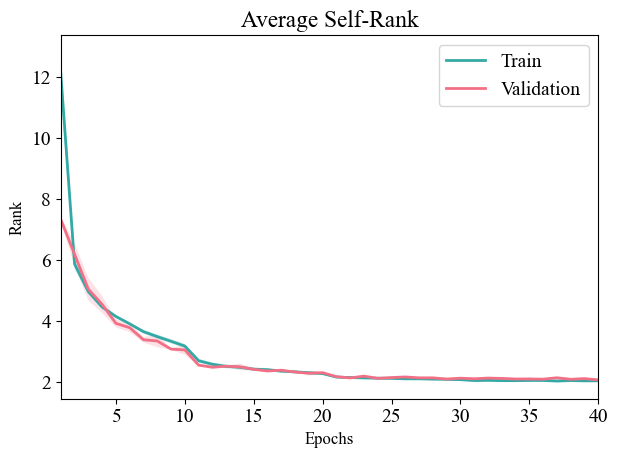

In [21]:
train_arr = np.asarray(cv_results['train_acc_mean_pos'])
val_arr = np.asarray(cv_results['val_acc_mean_pos'])
train_arr.shape, val_arr.shape
plot_train_test_losses(train_arr,val_arr, title="Average Self-Rank", x_label="Epochs", y_label="Rank",
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{run_name}_{USER}.png")

In [22]:
model = torch.load(f"results/RUN_{EXP_NAME}_{run_name}_{USER}_SelfSupervised.pth")

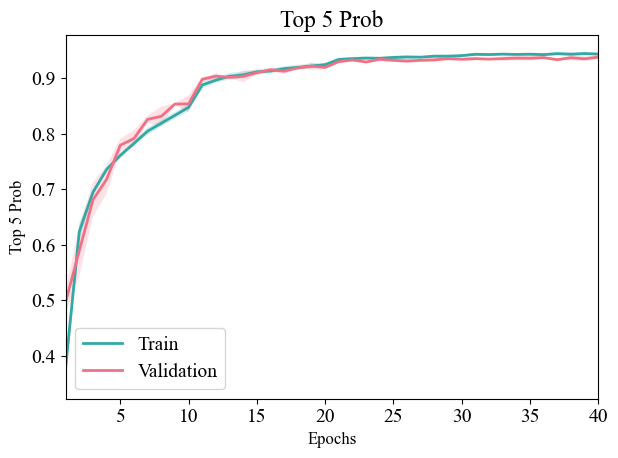

In [23]:
train_arr = np.asarray(cv_results['train_acc_top5'])
val_arr = np.asarray(cv_results['val_acc_top5'])
train_arr.shape, val_arr.shape
plot_train_test_losses(train_arr,val_arr, title="Top 5 Prob", x_label="Epochs", y_label="Top 5 Prob",
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{EXP_NAME}_{run_name}_{USER}.png")

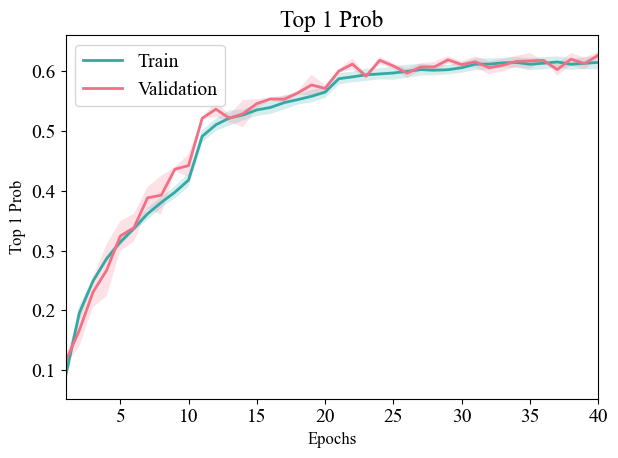

In [24]:
train_arr = np.asarray(cv_results['train_acc_top1'])
val_arr = np.asarray(cv_results['val_acc_top1'])
train_arr.shape, val_arr.shape
plot_train_test_losses(train_arr,val_arr, title="Top 1 Prob", x_label="Epochs", y_label="Top 1 Prob",
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{EXP_NAME}_{run_name}_{USER}.png")

# END
We change the rest if the code worked on full dataset.

In [ ]:
import csv

In [ ]:
# Format the date and time
now = datetime.now()
finish_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", finish_string)

In [ ]:
with open(f"results/RUN_{EXP_NAME}_{run_name}_{USER}.json", "w") as fp:
    json.dump(cv_results, fp, indent=4)

In [ ]:
cv_results["MAE"],cv_results['RMSE'],cv_results["R2"]

In [ ]:
cv_results_full = {}
cv_results_full['MAE_MEAN'] = np.mean(cv_results['MAE'])
cv_results_full['RMSE_MEAN'] = np.mean(cv_results['RMSE'])
cv_results_full['R2_MEAN'] = np.mean(cv_results['R2'])
cv_results_full['MAE_MEAN'],cv_results_full['RMSE_MEAN'],cv_results_full['R2_MEAN']

In [ ]:
cv_results_full['USE_LSTM_BRANCH'] = USE_LSTM_BRANCH
cv_results_full['NUM_CLIMATE_FEATURES'] = NUM_CLIMATE_FEATURES if USE_LSTM_BRANCH else None
cv_results_full['CSV_FILES'] = CSV_FILES if USE_LSTM_BRANCH else None
cv_results_full['NUM_WORKERS'] = NUM_WORKERS
cv_results_full['TRAIN_BATCH_SIZE'] = TRAIN_BATCH_SIZE
cv_results_full['TEST_BATCH_SIZE'] = TEST_BATCH_SIZE
cv_results_full['LEARNING_RATE'] = LEARNING_RATE
cv_results_full['NUM_EPOCHS'] = NUM_EPOCHS
cv_results_full['LR_SCHEDULER'] = LR_SCHEDULER
cv_results_full['CNN_ARCHITECTURE'] = CNN_ARCHITECTURE
cv_results_full['REG_VERSION'] = REG_VERSION
cv_results_full['USE_SPATIAL_ATTENTION'] = USE_SPATIAL_ATTENTION
cv_results_full['Best Seed'] = best_seed
cv_results_full['SEEDS'] = SEEDS
cv_results_full['OC_MAX'] = OC_MAX
cv_results_full['USE_SRTM'] = USE_SRTM
cv_results_full['TIME'] = {"start": start_string, "finish": finish_string}
cv_results_full['cv_results'] = cv_results

In [ ]:
with open(f"results/RUN_{EXP_NAME}_{run_name}_{USER}.json", "w") as fp:
    json.dump(cv_results_full, fp, indent=4)

In [ ]:
# READ JSON FILE
# with open("results/my_dict.json", "r") as fp:
#     my_dict = json.load(fp)

# print(my_dict)

# Analysis

## Save Outputs

### Loading the Best Model
Loading the best model from all the coross validation runs.

In [ ]:
load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),filename=f"results/RUN_{run_name}_{USER}.pth.tar")
model.eval()
print("Model loaded")

load saved model

In [ ]:
# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_05_T_16_02_Nafiseh.pth.tar') #LSTM 

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_03_T_09_41_Nafiseh.pth.tar') #GLAM 

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_02_T_20_57_Nafiseh.pth.tar') #Base

# model.eval()
# print("Model loaded")

In [ ]:
test_dl_w_id = DataLoader(test_ds_w_id, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
# test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/RUN_{run_name}_{USER}.csv")
# test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/onlytest_{run_name}_{USER}.csv")

## Visualize Spatial Attention

In [ ]:
if not USE_SPATIAL_ATTENTION or USE_LSTM_BRANCH:
    raise Exception("The Next Part of the Notebook is only available for the model with Spatial Attention and no LSTM Branch")

In [ ]:
BATCH_N = 1

IMG_IN_BATCH = 2

In [ ]:
batch_loader = BatchLoader(test_dl_w_id)

In [ ]:
batch = batch_loader(BATCH_N)
batch[0].shape, batch[1].shape, len(batch[2])

In [ ]:
import sys
import importlib
importlib.reload(sys.modules['plot_utils'])

In [ ]:
from plot_utils.plot import *
from PIL import Image

In [ ]:
# check if results/attention_maps folder exists if not create it
if not os.path.exists("results/attention_maps"):
    os.makedirs("results/attention_maps")

In [ ]:
ABS_ATT = False
ALPHA = 0.4
with torch.no_grad():
    pid = batch[2][IMG_IN_BATCH]
    print("Point Id:", pid)
    out = model(batch[0].to(device))
    print(out.shape)
    print(model.cnn.glam.local_spatial_att.att_map.shape)
    img_rgb = batch[0][0].permute(1,2,0)[:,:,[3,2,1]].detach().cpu().numpy()
    img_rgb = convert2uint8(normalize(img_rgb))
    
    att_map = model.cnn.glam.local_spatial_att.att_map
    att_map = F.interpolate(att_map, size=(64, 64), mode='bicubic', align_corners=True)[IMG_IN_BATCH].detach().cpu().numpy()[0]
    att_map = np.abs(att_map) if ABS_ATT else att_map
    att_map = convert2uint8(normalize(att_map))   
    
    colormap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    
    img_colormaped = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

    display_images(img_rgb, img_colormaped, ["Image", "Attention Map"], f"Local Attention Map Visualization | Point ID: {pid}", figsize=(10,5))
    

    
    
    cv2.imwrite(f"results/attention_maps/final/_{run_name}_{USER}_pid{pid}_img_lcl_colormaped.png", cv2.cvtColor(img_colormaped, cv2.COLOR_RGB2BGR))
    
    
    

In [ ]:
GLOB_ATT_CHANNEL = 510 # ranges between 0 and 511
with torch.no_grad():
    pid = batch[2][IMG_IN_BATCH]
    print("Point Id:", pid)
    out = model(batch[0].to(device))
    print(out.shape)
    print(model.cnn.glam.global_spatial_att.att.shape)
    img_rgb = batch[0][0].permute(1,2,0)[:,:,[3,2,1]].detach().cpu().numpy()
    img_rgb = convert2uint8(normalize(img_rgb))
    
    att_map = model.cnn.glam.global_spatial_att.att
    att_map = F.interpolate(att_map, size=(64, 64), mode='bicubic', align_corners=True)[IMG_IN_BATCH].detach().cpu().numpy()[GLOB_ATT_CHANNEL]
    att_map = np.abs(att_map) if ABS_ATT else att_map
    att_map = convert2uint8(normalize(att_map))   
    
    colormap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    
    img_colormaped = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

    display_images(img_rgb, img_colormaped, ["Image", "Attention Map"], f"Global{GLOB_ATT_CHANNEL} Attention Map Visualization | Point ID: {pid}") 
                #    figsize=(10,5), savepath=f"results/attention_maps/final/RUN_{run_name}_{USER}_pid{pid}_glb{GLOB_ATT_CHANNEL}.png")
    
    # # Save img_rgband img_colormaped as jpg files
    # cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_glb{GLOB_ATT_CHANNEL}_rgb.png", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    # cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_glb{GLOB_ATT_CHANNEL}_colormaped.png", cv2.cvtColor(img_colormaped, cv2.COLOR_RGB2BGR))
    
    
    